# End-to-end Multi-class Dog Breed Identification

End-to-end Multil-class Dog Breed Classification

# Problem Definition

> When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

# Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

Some information about the data:
* We're dealing with images (unstructured data) so it's best to use deep learning/transfer learning.
* There are 120 breeds of dogs/classes.
* There are around 10,000+ images in the both the training & test sets.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub 

In [110]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

In [3]:
tf.__version__, hub.__version__

('2.9.1', '0.12.0')

### Data Exploration

In [4]:
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


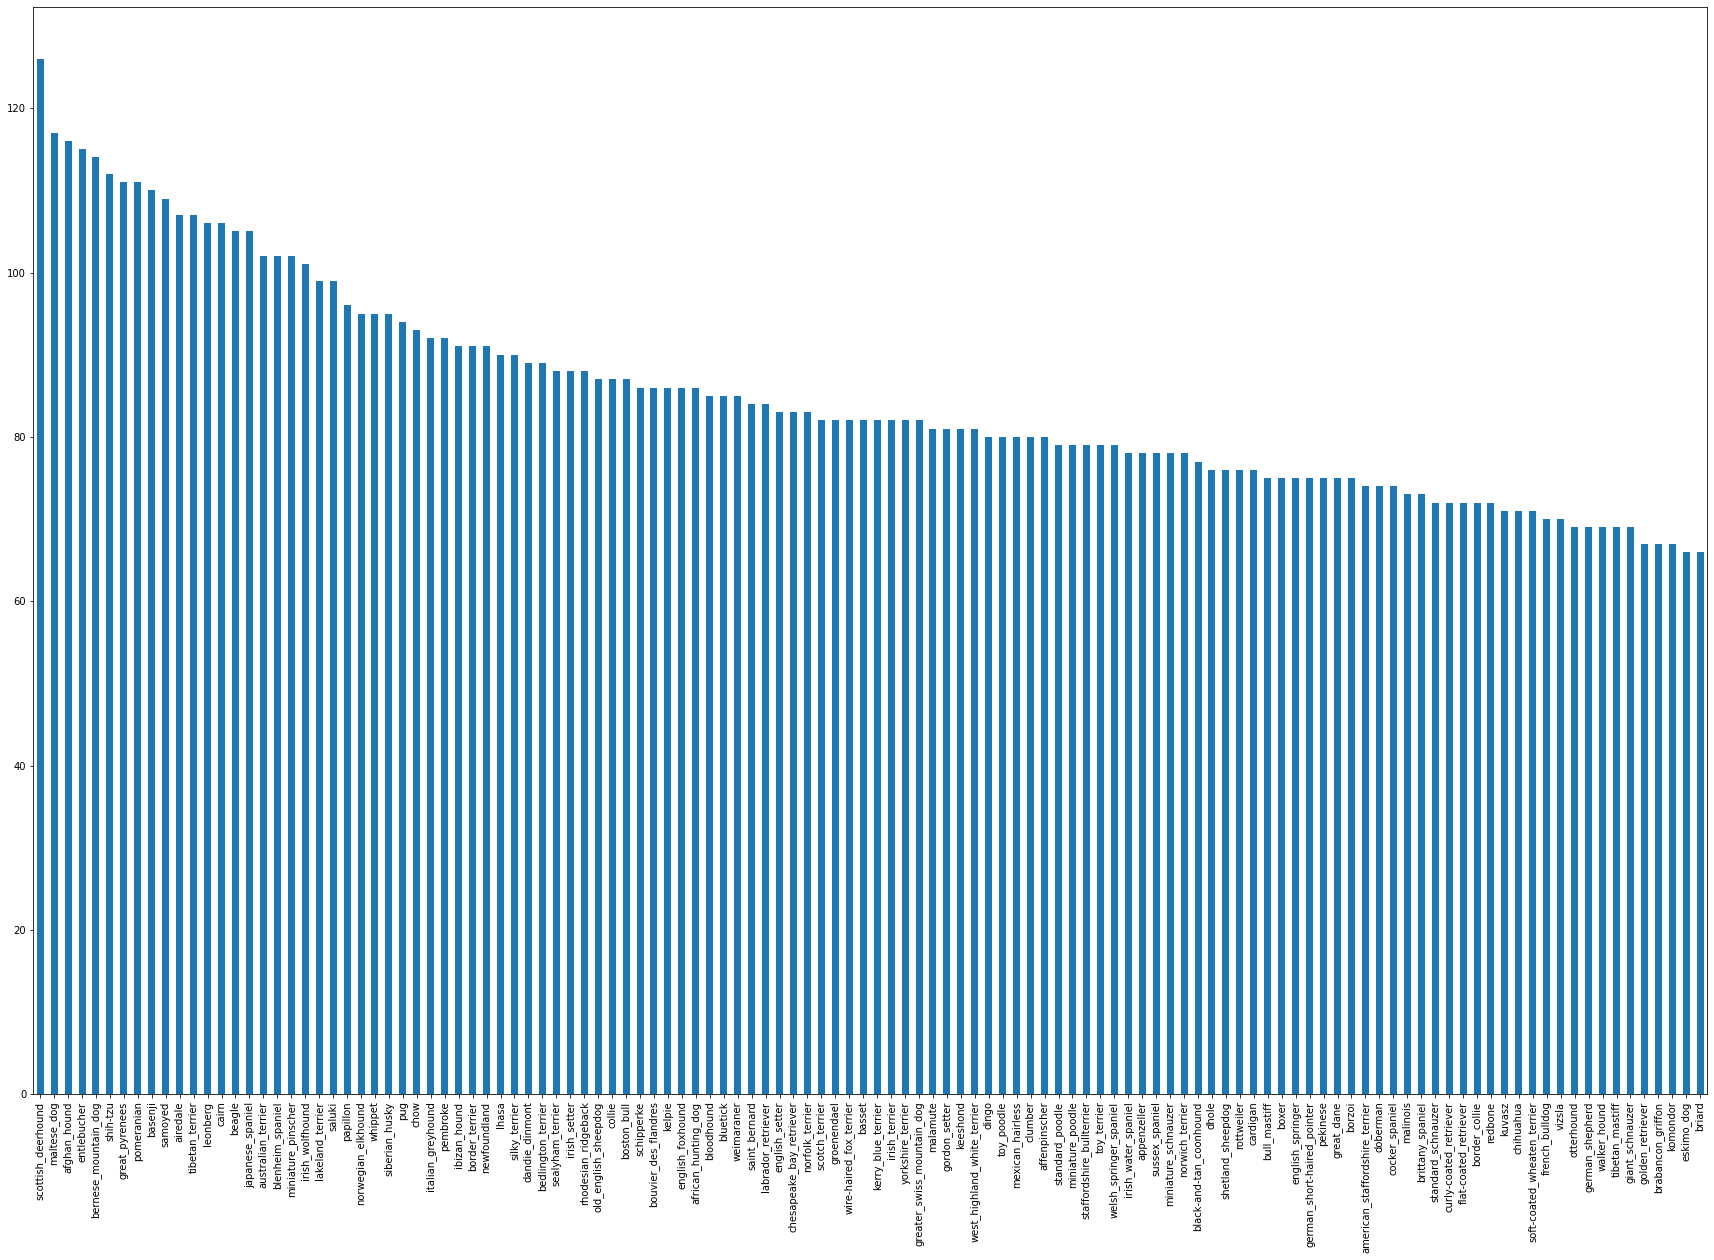

In [6]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(30, 20));

In [7]:
labels_csv['breed'].value_counts().median()

82.0

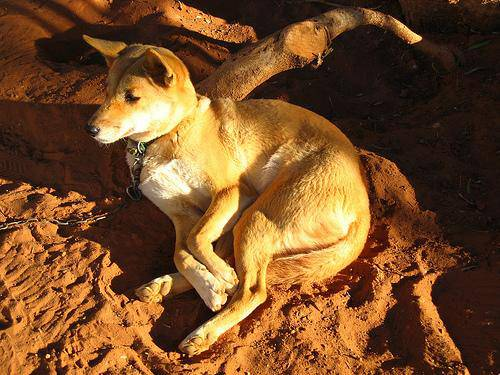

In [8]:
Image.open('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

In [9]:
# Check all unique breeds
labels = labels_csv['breed'].to_numpy()
filenames = [f'data/train/{fname}.jpg' for fname in labels_csv['id']]
unique_breeds = np.unique(labels)
filenames[:10], unique_breeds

(['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
  'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg'],
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'b

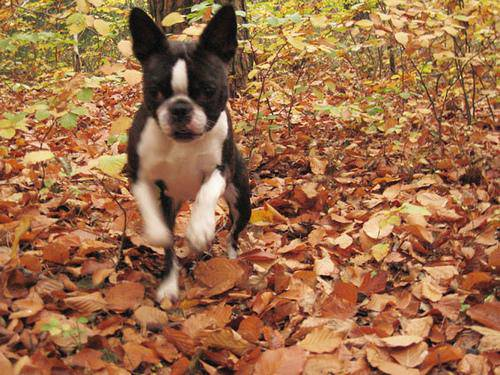

In [10]:
Image.open(filenames[0])

### Create Validation Set

Kaggle doesn't provide a validation set

In [11]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [12]:
# Use subset of samples for faster experimentation
NUM_IMAGES = 1000
X = filenames
y = boolean_labels

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocess Images (Convert unstructured data to Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1)
5. Resize the image to be a shape of (224, 224) and return it

In [14]:
test_image = plt.imread(filenames[0])

# 3-dimensional (RGB each from 0 to 255)
test_image.shape, test_image.max(), test_image.min()

((375, 500, 3), 255, 0)

In [15]:
# Image numPy array as a tensor
tf.constant(test_image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  7

In [16]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor of RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

### Create batches

Processing 10,000+ images in one go might not fit in memory; the preferred choice of batch size is usually 32

In order to use TensorFlow effectively, the data must be in the form of Tensor tuples which look like: (image, label).

In [17]:
# Create a function to return a Tensor tuple (image, label)
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

In [18]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    # test data doesn't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # No need to shuffle validation data: there's no use
    if valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices(
            (tf.constant(X), tf.constant(y))
        )
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices(
        (tf.constant(X), tf.constant(y))
    )

    # Shuffling (to prevent model learning on any orders/patterns) this
    # is faster than images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples & convert to batches
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [19]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


### Visualize batches

In [20]:
# Create a function for viewing images in a data batch
def show_n_images(images, labels, n=25):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        ax = plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1) 
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis('off')

In [21]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [22]:
# Shuffled - returns different images each time
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

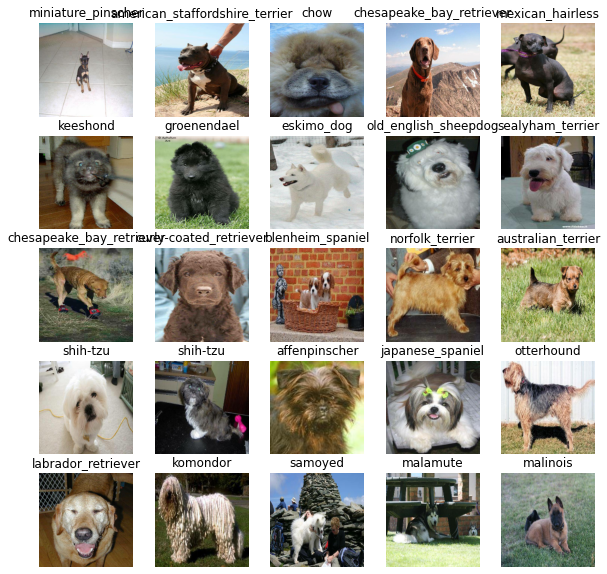

In [23]:
show_n_images(train_images, train_labels, 25)

In [24]:
val_images, val_labels = next(val_data.as_numpy_iterator())
len(val_images), len(val_labels)

(32, 32)

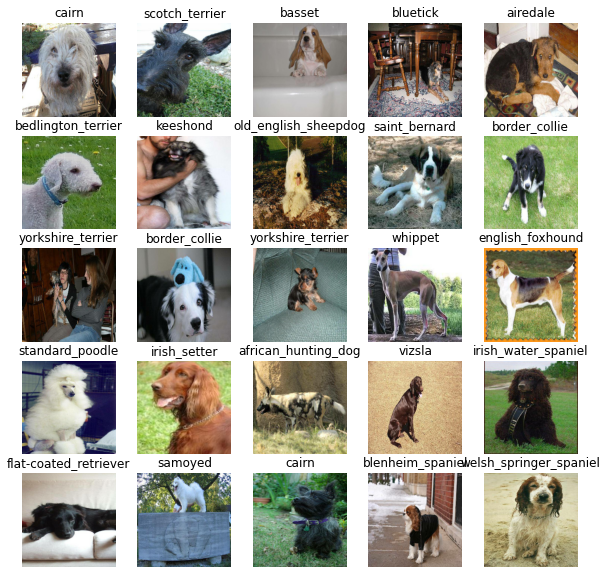

In [25]:
show_n_images(val_images, val_labels, 25)

# Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
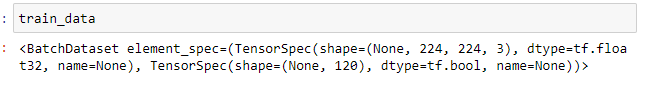

* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [26]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

### Create a model

let's create a function which:

* Takes the input shape, output shape and the model we've chosen.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Builds (tells the model the input shape it'll be getting) & returns the model .

https://www.tensorflow.org/guide/keras/overview

In [27]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        # Layer 1 (input layer)
        hub.KerasLayer(MODEL_URL),
        # Layer 2 (output layer)
        tf.keras.layers.Dense(
            units=OUTPUT_SHAPE,
            activation='linear'
        )
    ])

    # Compile the model
    model.compile(
      # Use CategoricalCrossEntropy since our labels are OHE
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [28]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Create callback functions

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks:
* TensorBoard
* Early Stopping

*Early Stopping*

Helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

*TensorBoard*

Helps track our models progress

In [30]:
%load_ext tensorboard
import datetime

# Build a TensorBoard callback
def create_tensorboard_callback():
    # Location to store TensorBoard logs
    logdir = os.path.join(
        'logs',
        # Track logs whenever we run an experiment (fit a model)
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return tf.keras.callbacks.TensorBoard(logdir)

### Train model on the subset (only 1000 images)

Let's create a function which:
* Creates a model
* Setup a TensorBoard callback
* Return the model fitted on the training data, validation data, number of epochs to train for and the callbacks we'd like to use

In [31]:
NUM_EPOCHS = 10

In [32]:
# Build a function to train and return a trained model
def train_model():
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data with the callbacks
    model.fit(
        x=train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard, early_stopping]
    )

    # Return the fitted model
    return model

In [33]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/10
25/25 [==============================] - 44s 1s/step - loss: 4.5570 - accuracy: 0.0887 - val_loss: 3.3946 - val_accuracy: 0.3000
Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 1.5988 - accuracy: 0.6862 - val_loss: 2.2090 - val_accuracy: 0.5250
Epoch 3/10
25/25 [==============================] - 37s 1s/step - loss: 0.5578 - accuracy: 0.9375 - val_loss: 1.7403 - val_accuracy: 0.5950
Epoch 4/10
25/25 [==============================] - 33s 1s/step - loss: 0.2530 - accuracy: 0.9800 - val_loss: 1.5267 - val_accuracy: 0.6250
Epoch 5/10
25/25 [==============================] - 37s 2s/step - loss: 0.1445 - accuracy: 0.9975 - val_loss: 1.4448 - val_accuracy: 0.6300
Epoch 6/10
25/25 [==============================] - 33s 1s/step - loss: 0.0991 - accuracy: 1.0000 - val_loss: 1.3955 - val_accuracy: 0.6500
Epoch 7/10
25/25 [==============================] - 34s 1s/step - l

__Model seems to be overfitting__: performs better in training set but quite bad in validation set

In [34]:
# Visualize tensorboard logs
# %tensorboard --logdir logs

# Creating Predictions

In [35]:
# Parse predictions into softmax function to convert them to probabilities
predictions = tf.nn.softmax(model.predict(val_data, verbose=1)).numpy()

7/7 [==============================] - 7s 865ms/step


In [36]:
# Predict single example
index = 42

print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

Max value (probability of prediction): 0.5805228352546692
Max index: 39
Predicted label: english_foxhound


In [37]:
# Create a function to turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[index])
pred_label

'english_foxhound'

In [38]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

### Unbatchify validation data

Since our valid data is still in a batch dataset, we'll have to "unbatchify" it to get the images - to make predictions on - & the true labels.

In [39]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

### Plot predictions

We'll create a function which:

* Takes the pred probs, truth labels, images and image index.
* Obtain the predicted label & create a plot, alongside the above-mentioned data.

In [40]:
# Create a function to plot the predictions of an image
def plot_pred(prediction_probabilities, labels, images, n=1):
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title(
        f'Predicted: {pred_label} with confidence {round(np.max(pred_prob) * 100)}%. True label: {true_label}',
        color=color
    )

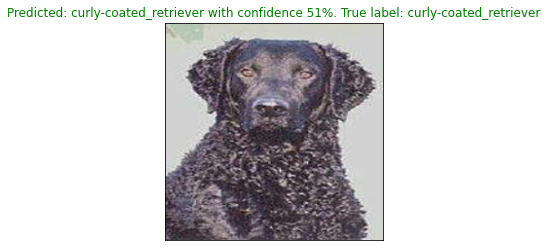

In [41]:
plot_pred(
    prediction_probabilities=predictions,
    labels=val_labels,
    images=val_images,
    n=76
)

### Plot top 10 predictions

We'll create a function which:

* Take an input of prediction probabilities, ground truths and image index
* Find the top 10 prediction probabilities indexes, values & labels
* Plot the top 10 prediction probability values and labels

In [42]:
# Create a function to plot the top 10 highest prediction confidences of an image
def plot_preds(prediction_probabilities, labels, n=1):
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(
        np.arange(len(top_10_pred_labels)),
        top_10_pred_values,
        color='grey'
    )

    plt.xticks(
        np.arange(len(top_10_pred_labels)),
        labels=top_10_pred_labels,
        rotation='vertical'
    )
    
    # Change color of predicted label (its at index of max confidence)
    top_plot[np.argmax(top_10_pred_values)].set_color('blue')

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')

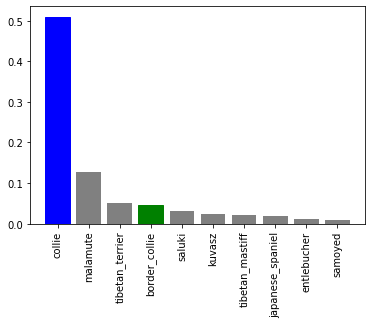

In [43]:
plot_preds(
    prediction_probabilities=predictions,
    labels=val_labels,
    n=9
)

In [58]:
# Visualize a number of predictions
def plot_many_preds(start_index=20):
    num_rows = 3
    num_cols = 2
    num_images = num_rows * num_cols
    plt.figure(figsize=(10 * num_cols, 5 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_pred(
            prediction_probabilities=predictions,
            labels = val_labels,
            images = val_images,
            n = i + start_index
        )

        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_preds(
            prediction_probabilities=predictions,
            labels = val_labels,
            n = i + start_index
        )

    plt.tight_layout(h_pad = 1.0)
    plt.show()

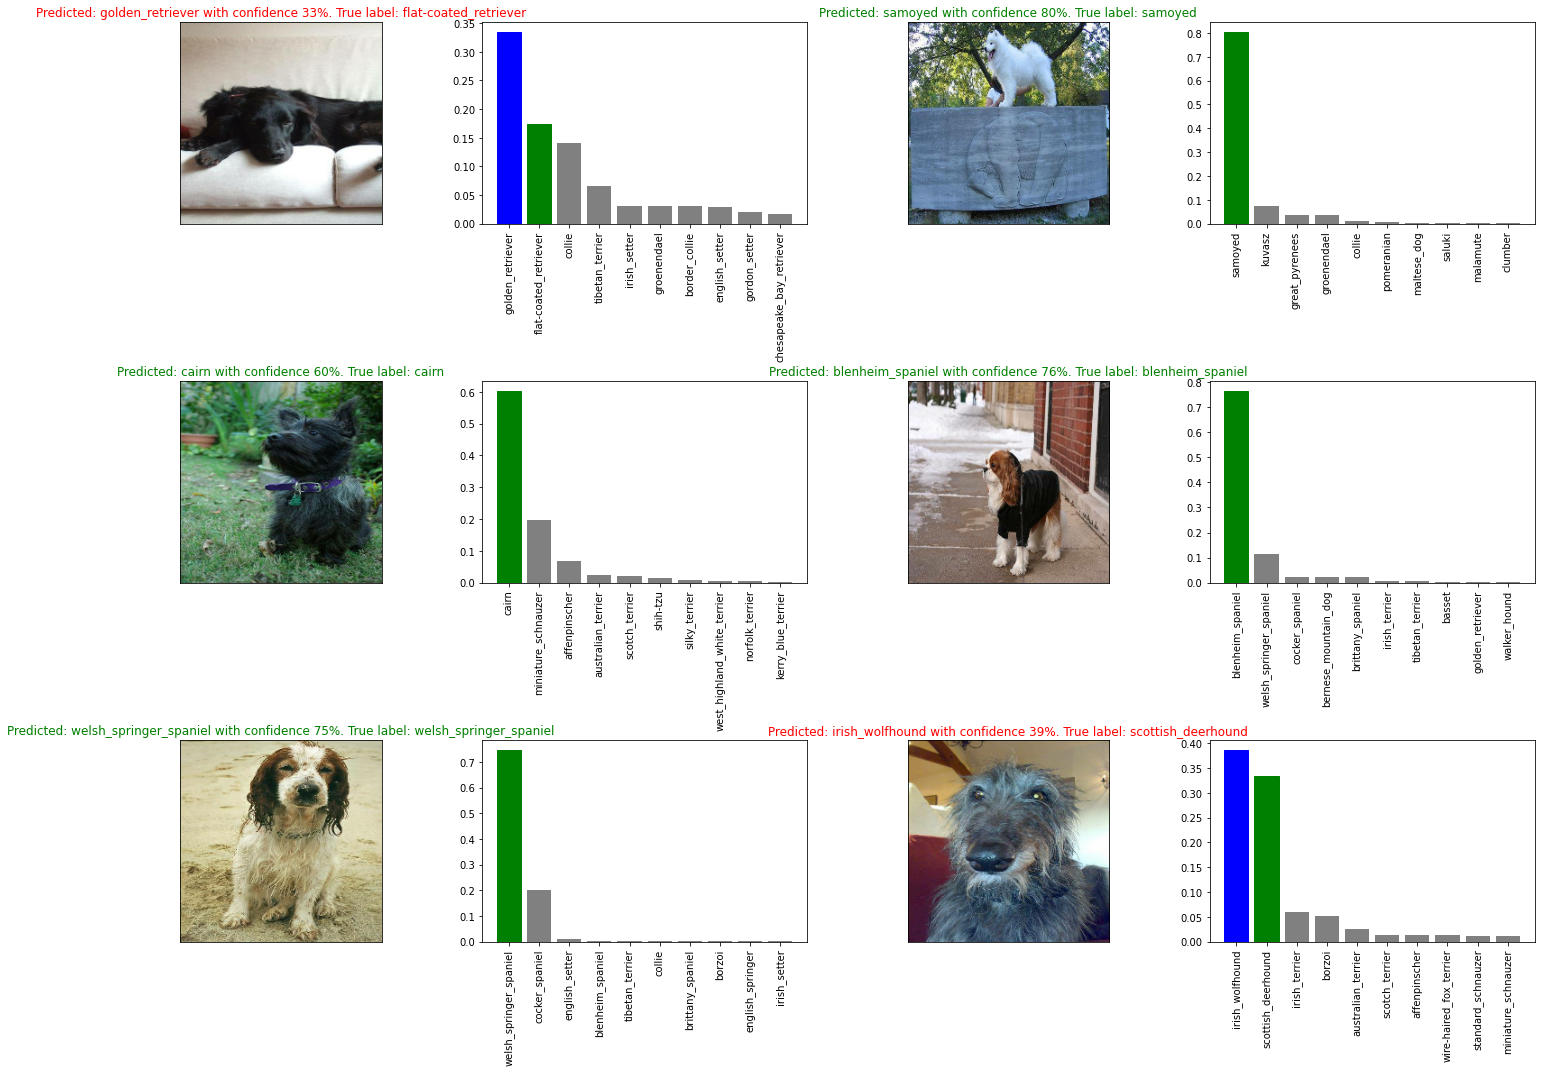

In [59]:
plot_many_preds()

# Saving & Loading Model

In [66]:
# Create a function to save a model
def save_model(model, suffix=None):
    # Create a model directory pathname with current time
    modeldir = os.path.join(
      'models',
      datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    )

    model_path = f'{modeldir}-{suffix}.h5'
    print(f'Saving model to: {model_path}...')
    model.save(model_path)
    return model_path

In [67]:
# Create a function to load a trained model
def load_model(model_path):
    print(f'Loading saved model from: {model_path}')
    model = tf.keras.models.load_model(
        model_path,
        
        # Since we have added a layer from tensorflow hub (not keras), this is required
        custom_objects={"KerasLayer":hub.KerasLayer}
    )

    return model

In [69]:
suffix='1000-images-mobilenetv2-Adam'
save_model(model, suffix=suffix)

Saving model to: models\20220908-064618-1000-images-mobilenetv2-Adam.h5...


'models\\20220908-064618-1000-images-mobilenetv2-Adam.h5'

In [70]:
loaded_image_model = load_model(f'models/20220908-064618-{suffix}.h5')

Loading saved model from: models/20220908-064618-1000-images-mobilenetv2-Adam.h5


In [71]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 7s 1s/step - loss: 1.3335 - accuracy: 0.6450


[1.333493709564209, 0.6449999809265137]

In [72]:
# Evaluate the loaded model
loaded_image_model.evaluate(val_data)

7/7 [==============================] - 8s 901ms/step - loss: 1.3335 - accuracy: 0.6450


[1.333493709564209, 0.6449999809265137]

# Evaluate model

To create an evaluation report and confusion matrix the requirement is a 1D Tensor of the labels and predictions

In [74]:
predictions

array([[1.27840880e-03, 1.90346866e-04, 3.72747221e-04, ...,
        8.86947382e-04, 1.54770023e-05, 2.43511354e-03],
       [4.31651063e-03, 5.95579681e-04, 8.15989263e-03, ...,
        6.17393598e-05, 3.01812124e-03, 2.58524615e-05],
       [1.27688269e-04, 1.30774541e-04, 3.23356471e-05, ...,
        1.16983756e-04, 6.13338416e-05, 6.72252907e-04],
       ...,
       [3.52258394e-06, 9.07345657e-06, 1.96175333e-05, ...,
        1.49599930e-06, 1.15256866e-04, 8.35774772e-05],
       [4.46088314e-02, 2.36859283e-04, 6.02529326e-04, ...,
        5.36856183e-04, 3.26447742e-04, 1.55906389e-02],
       [3.54740594e-04, 3.62765859e-04, 8.02793261e-03, ...,
        6.79169074e-02, 2.21982220e-04, 5.89771313e-04]], dtype=float32)

In [103]:
# Convert the val labels to array of highest indexes
bool_val_labels = [label == unique_breeds for label in val_labels]
val_labels_indexes = np.argmax(bool_val_labels, axis=1)
val_labels_indexes

array([ 26,  96,   8,  15,   3,  10,  62,  82,  92,  16, 119,  16, 119,
       117,  39, 105,  56,   2, 112,  58,  44,  94,  26,  13, 115,  97,
        65,  81,  27,  37,  35, 113, 113,  74,  43, 101, 115,  38,  74,
        66,  67, 118,  39,  33, 110,  54,  19, 105,  76,  29, 104, 112,
        79,  88,  10,   0,  17,  99,  28,  67,  76, 118,   1,  38,  48,
        35,   7,  22,  94,   3,  74,  78,  15,  84,  28,   3,  34,  54,
        72,  31,  88,  56,  85,   5,  34, 101, 108,  93,  79,  86,  39,
        87, 119, 113,  71,  57,  33,  42,   6,  51,  14,  11, 118,   5,
        29,  90, 102,  70,  18,  25,  32,   9,  36,  35,  93,  94, 104,
        40,  85, 114,   9,  63,  91,  81,  97,  79,  81,  35,  33,  63,
        97,  32,  11,  64, 115,  48,  57,  28,  49,  24,   0,  64,  94,
       110,   1,  44,  24,  60,  32,  21, 106,  83,  94,   8,  98,  28,
       117,   1,  46,  22, 110,  13,  10,   5,   2,  61,  10,  23,  31,
        87,  63,   7,  93,  34,  11,  98, 117, 103,  87,  51,  5

In [104]:
# Convert the val predictions to array of highest indexes
val_prediction_indexes = np.argmax(predictions, axis=1)
val_prediction_indexes

array([ 26,  96,   8, 119,   3,  10,  80,  82,  92,  33, 119,  49, 119,
        60,  39,  76,  56,   2,  67,  58,  49,  94,  26,  13, 115,  59,
        65,  26,  27,  37,  35, 113, 113,  74,  71, 101, 115,  38,  36,
        49,  67,  68,  39,  16,  76,  54,  19,  76,  76,   6, 104, 112,
        79,  88, 110,   0,  17,  99,  28,  67, 110, 118,   1,  38,  48,
        68,   7,   0,  94, 110,  74,  78,  15,  84,  28,   3,  34,  54,
        72,  31,  93,  37,  85,  75,  58, 101,  78,  93,  79,  86,  39,
        87, 119, 113,  71,  57, 115,  53,   6,  51,  67,  11,   6,  11,
        60,  90,   6, 100,  18,  25,  68,  53,  36,  68,  93,  52,   7,
        40,  85, 114,   9,  95,  67,  81,  97,  81,   6,   6,  33,  95,
        40,  32,  11,  64, 115,  20,  57, 114,  49,  24,   0,  64,  94,
       110,   1,  33, 115,  60, 115,  21,  59,  83,  94,   8,  98,  28,
       117,   1,  46,   0, 110,  13,  10,  42,   2,  61,  10, 106,  31,
        87,  95,   7,  70,  34,  11,  82,  77,  70,  29,  38,  5

In [107]:
classif_report = classification_report(val_labels_indexes, val_prediction_indexes)
print(classif_report)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         4
           6       0.17      1.00      0.29         1
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      0.75      0.86         4
          11       0.75      1.00      0.86         3
          13       1.00      0.75      0.86         4
          14       0.00      0.00      0.00         1
          15       1.00      0.67      0.80         3
          16       0.00      0.00      0.00         2
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00    

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [108]:
cf_matrix = tf.math.confusion_matrix(
    np.argmax(bool_val_labels, axis=1), np.argmax(predictions, axis=1)
).numpy()

cf_matrix

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 3]])